# Clustering Countries - Indirect Effects

In [1]:
%matplotlib notebook

from IPython.display import display_html 

from tools import Preprocessing, Clustering, benchClustering, plotBarh, highlight_max

import pandas as pd
import numpy as np

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
import hdbscan
from scipy.cluster import hierarchy


from fancyimpute import KNN

import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tl

import matplotlib as mpl
import matplotlib.pyplot as plt
import bqplot as bqp
# from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pylab

import ipyvolume as ipv
from ipywidgets import FloatSlider, ColorPicker, VBox, jslink


sns.set(context='notebook', style='whitegrid', font='sans-serif',
        palette='muted', font_scale=1, color_codes=True, rc=None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 10000)

Using TensorFlow backend.


In [2]:
# # import the csv dataset as a pandas DataFrame
# df = pd.read_csv('data/full_data.csv')
# df.columns
# list(df.columns)

"**Indirect effects** occur to industries in the backward­linked industries that supply the exporting firm." [Wayne P. Miller]

So, what does the indirect economic impact of an **off-shore oil platform** depends upon?


1. **Development of the oil sector** of the country
     - Hp: the more developed the  oil industry is, the higher the availability of specialized suppliers
     
 
2. **Industrial development of the country**
     - Hp: the more industrialized the country is, the higher the likelihood that suppliers will source locally
     
 
3. Level of **import** of goods and services
     - Hp: the more the country is open to import, the lower the likelihood that suppliers will source locally

### Clustering variables
1. Production of Oil, cumulated 2007-2017 [bdp] 
2. MVApe_constantUS$_2015 : Manufactoring Value Added per employee, 2015
3. Import of Goods and Services w.r.t. GDP, 2014-2016 average

All these variables have been standardized for clustering.

In [47]:
varlist = [
    'Production_Oil_bdp_Cumulated',
    'MVApc_constantUS$_2015',
    'ImportGoodsServices_%GDP',
#    'MVApc_constantUS$_2015',
#   'Production_Oil_bpd_2014',
#   'Production_Oil_bpd_2015',
#   'MHMVAsh%_2015', ???
          ]

In [48]:
prep = Preprocessing('data/full_data.csv',
                     varlist=varlist, verbose=True)
prep.exportCSV('data/cleaned_data_economic.csv', impute=True)

MISSING VALUES FOR EACH FEATURE:
MVApc_constantUS$_2015      3
ImportGoodsServices_%GDP    1
dtype: int64 

MISSING VALUES FOR EACH COUNTRY:
Country Code
TKM    2
TLS    1
LBY    1
dtype: int64


Let's visualize our dataset a bit:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


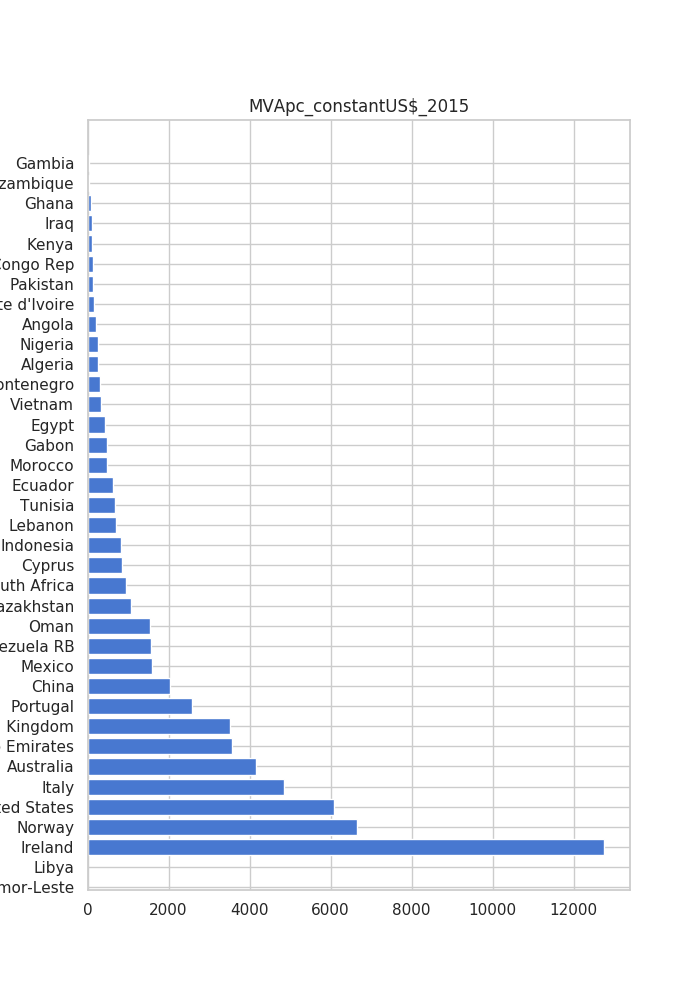

<IPython.core.display.Javascript object>

In [49]:
for c in prep.df.columns[1:]:
    plotBarh(df=prep.df, by_column=c )

In [7]:
data = Clustering('data/cleaned_data_economic.csv', verbose=False)

In [8]:
x = data.df.iloc[:, 0]
y = data.df.iloc[:, 1]
z = data.df.iloc[:, 2]

selected = None
ipv.figure()
scatter = ipv.pylab.scatter(x, y, z, marker="sphere", color = 'red', size=5, size_selected=8, selected=selected)
# ipv.pylab.xyzlabel(x.name, y.name, z.name)

size = FloatSlider(min=0, max=30, step=0.1)
size_selected = FloatSlider(min=0, max=30, step=0.1)
color = ColorPicker()
color_selected = ColorPicker()
jslink((scatter, 'size'), (size, 'value'))
jslink((scatter, 'size_selected'), (size_selected, 'value'))
jslink((scatter, 'color'), (color, 'value'))
jslink((scatter, 'color_selected'), (color_selected, 'value'))

In [9]:
print('x = ', x.name)
print('y = ', y.name)
print('z = ', z.name)
VBox([ipv.gcc(), size, size_selected, color, color_selected])

x =  Production_Oil_bdp_Cumulated
y =  MVApe_constantUS$_2015
z =  ImportGoodsServices_%GDP


CUMULATIVE PROPORTION OF VARIANCE EXPLAINED BY PCs


<IPython.core.display.Javascript object>


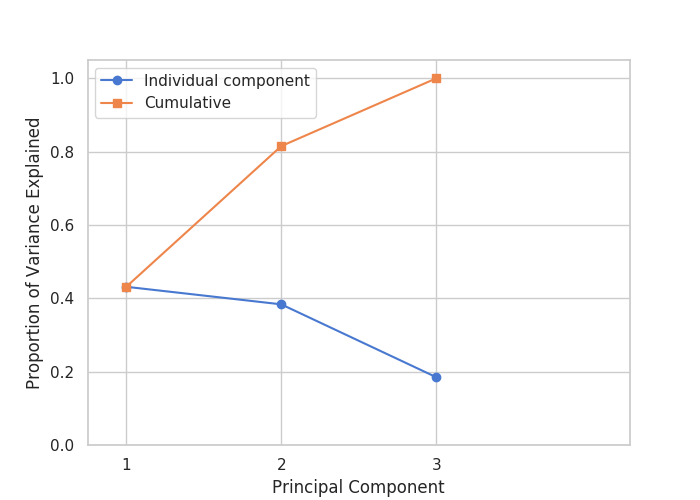

<IPython.core.display.Javascript object>


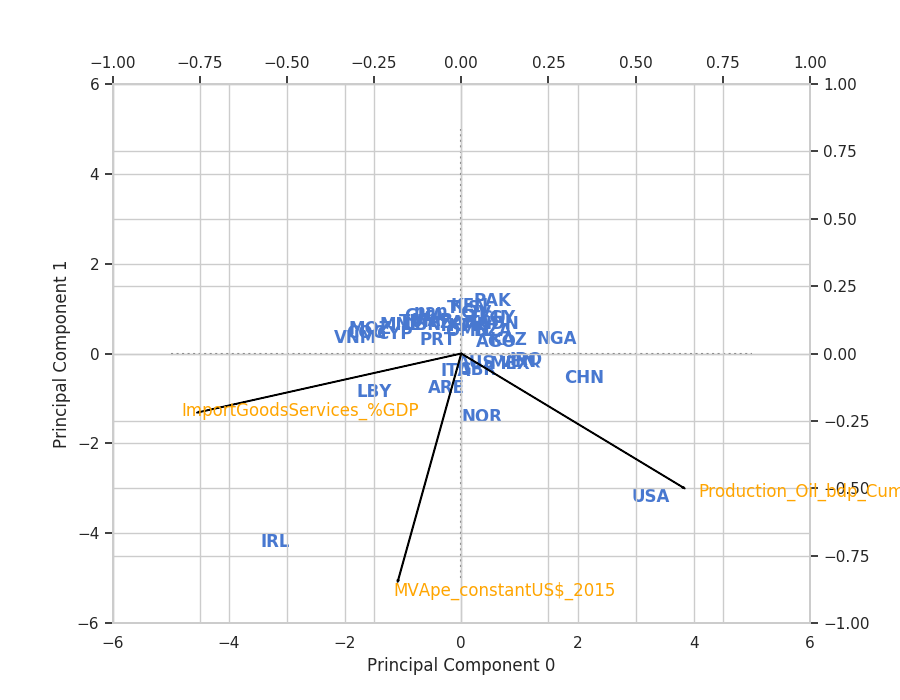

In [10]:
data.getPC()
data.plotAlongPC(pc1=0, pc2=1, xlim=[-6, 6], ylim=[-6, 6], loadings=True, clustering=None)

Let's implement various clustering techniques and compare their results:
 - **K-Means CLustering** (spherical clusters, fixed number)
 - **Hierarchical Agglomerative Clustering** (spherical clusters, adaptive)
 - **Gaussian Mixtures Model** (elliptical clusters, fixed number)
 - **Bayesian Gaussian Mixtures Model** (elliptical clusters, adaptive)

Some more information on the clustering techniques:

- **K-Means CLustering** : clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. 
- **Ward Hierarchical Clustering** : minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
- **Gaussian Mixtures Model** : a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.
- **Bayesian Gaussian Mixtures Model** : implements a variant of the Gaussian mixture model with variational inference algorithms. 

![caption](files/comparing_clustering_methods.png)

<IPython.core.display.Javascript object>


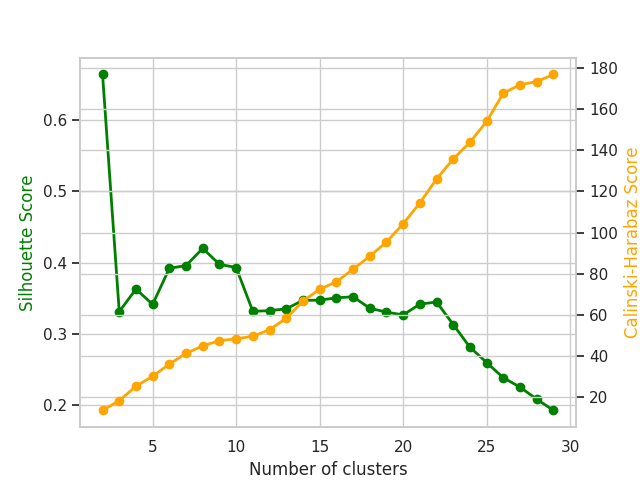

In [14]:
on_PC = 0
n_init = 100
k_min = 2
k_max = 30
silh, calha = data.multipleKmeans(k_min=k_min, k_max=k_max, on_PC=on_PC, n_init=n_init)

In [15]:
k_clusters = 8
data.kmeans(n_clusters=k_clusters, on_PC=on_PC, n_init=n_init)
# k_clusters = 10
# data.kmeans(n_clusters=k_clusters, on_PC=on_PC, n_init=n_init)
# data.clusterings['kmeans'+str(n_clusters)]

the minimum BIC is achieved with               24 gaussian components


<IPython.core.display.Javascript object>


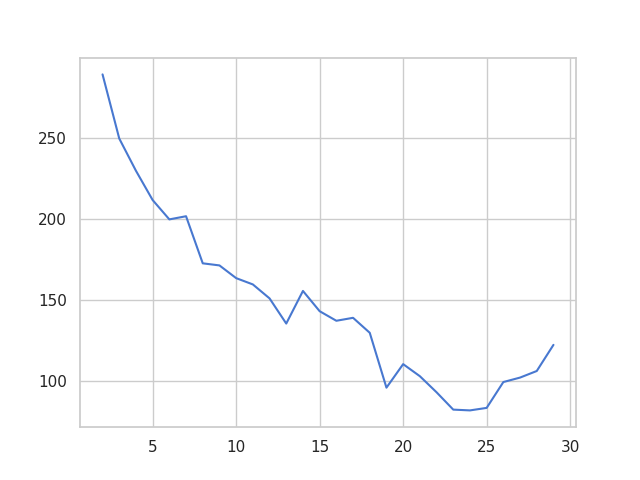

In [28]:
data.gmBIC(n_min=k_min, n_max=k_max, covariance_type='full', n_init=n_init, on_PC=on_PC)

In [34]:
n_components = 14
data.gaussianMixture(n_components, covariance_type='full', n_init=n_init, on_PC=0)
data.bayesianGaussianMixture(n_components, covariance_type='full', n_init=n_init, on_PC=0)

In [18]:
data.hdbscan(min_cluster_size=2, on_PC=on_PC)

<IPython.core.display.Javascript object>


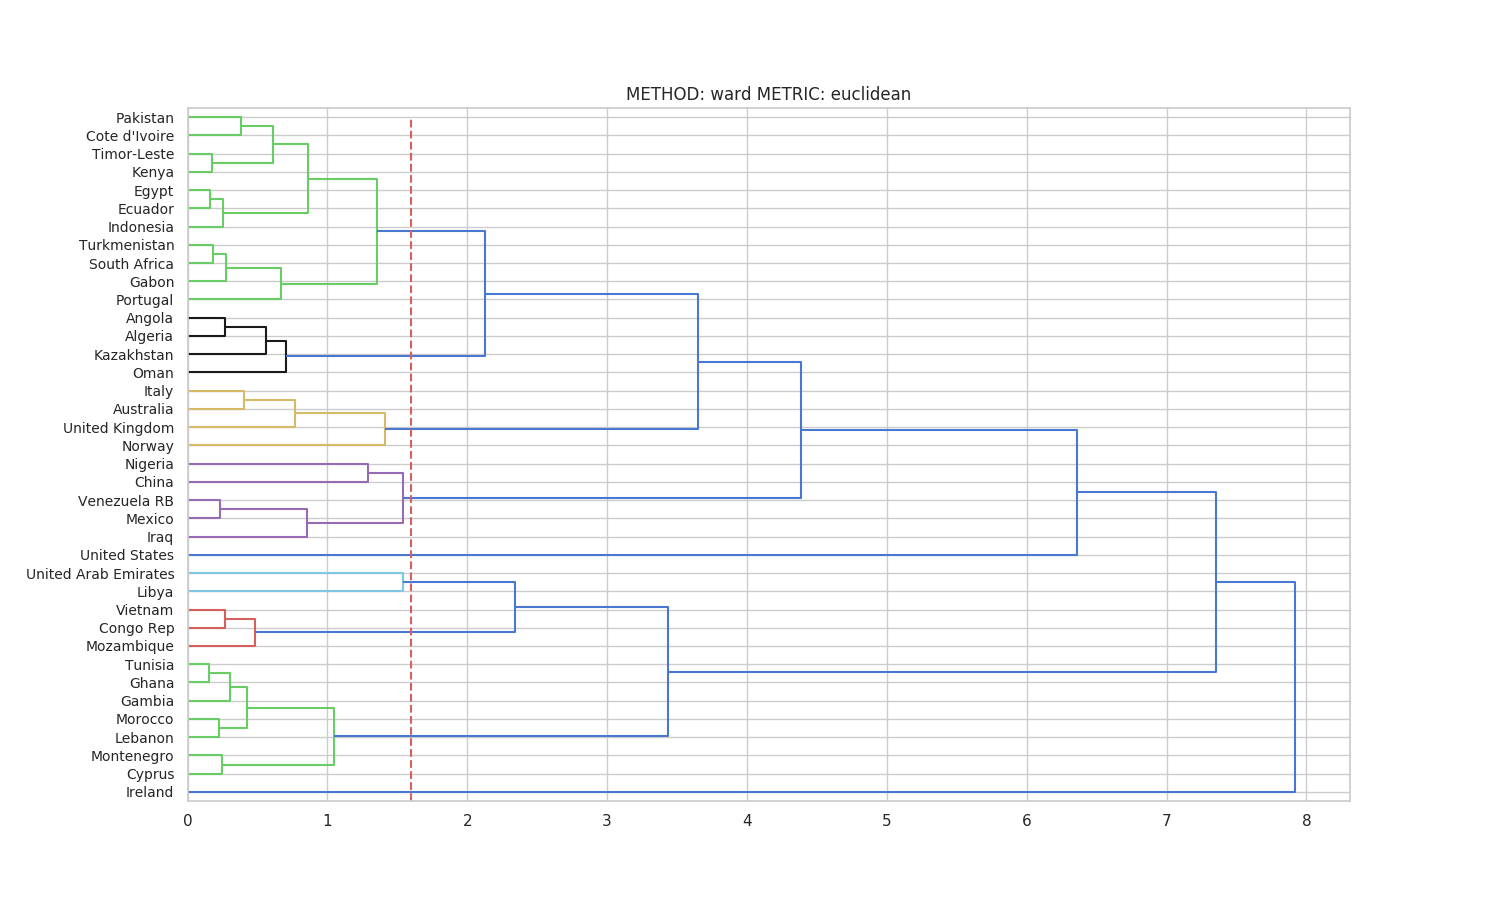

In [19]:
data.hierarchicalClustering(metric='euclidean', method='ward', threshold=1.6, on_PC=0, heatmap=False)

In [16]:
#data.hierarchicalClustering(metric='euclidean', method='ward', threshold=2, on_PC=0, heatmap=False)

<IPython.core.display.Javascript object>


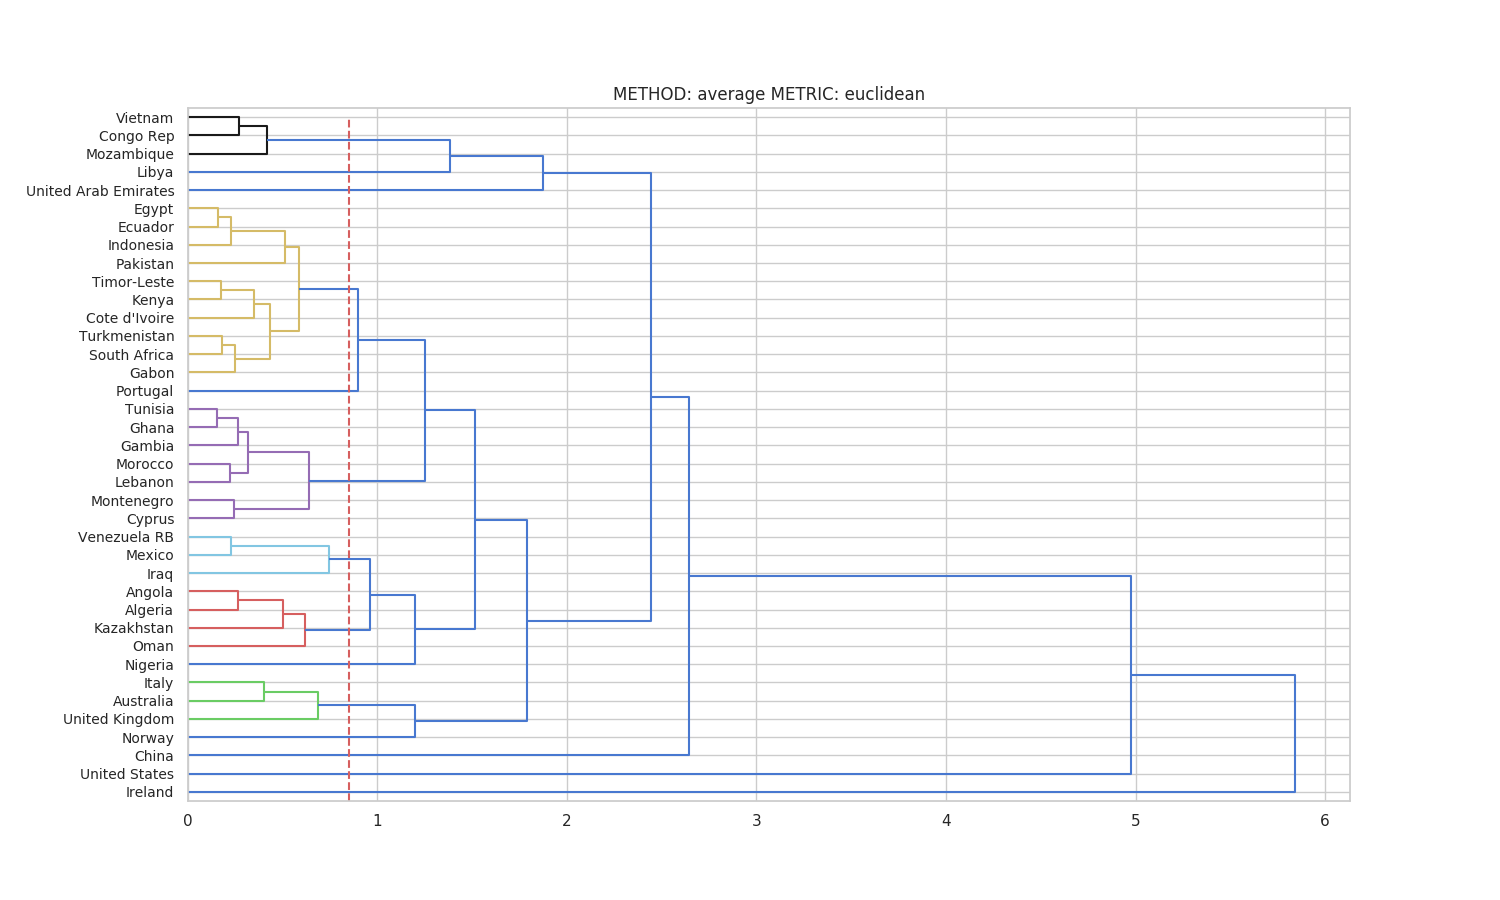

In [20]:
data.hierarchicalClustering(metric='euclidean', method='average', threshold=0.85, on_PC=0, heatmap=False)

<IPython.core.display.Javascript object>


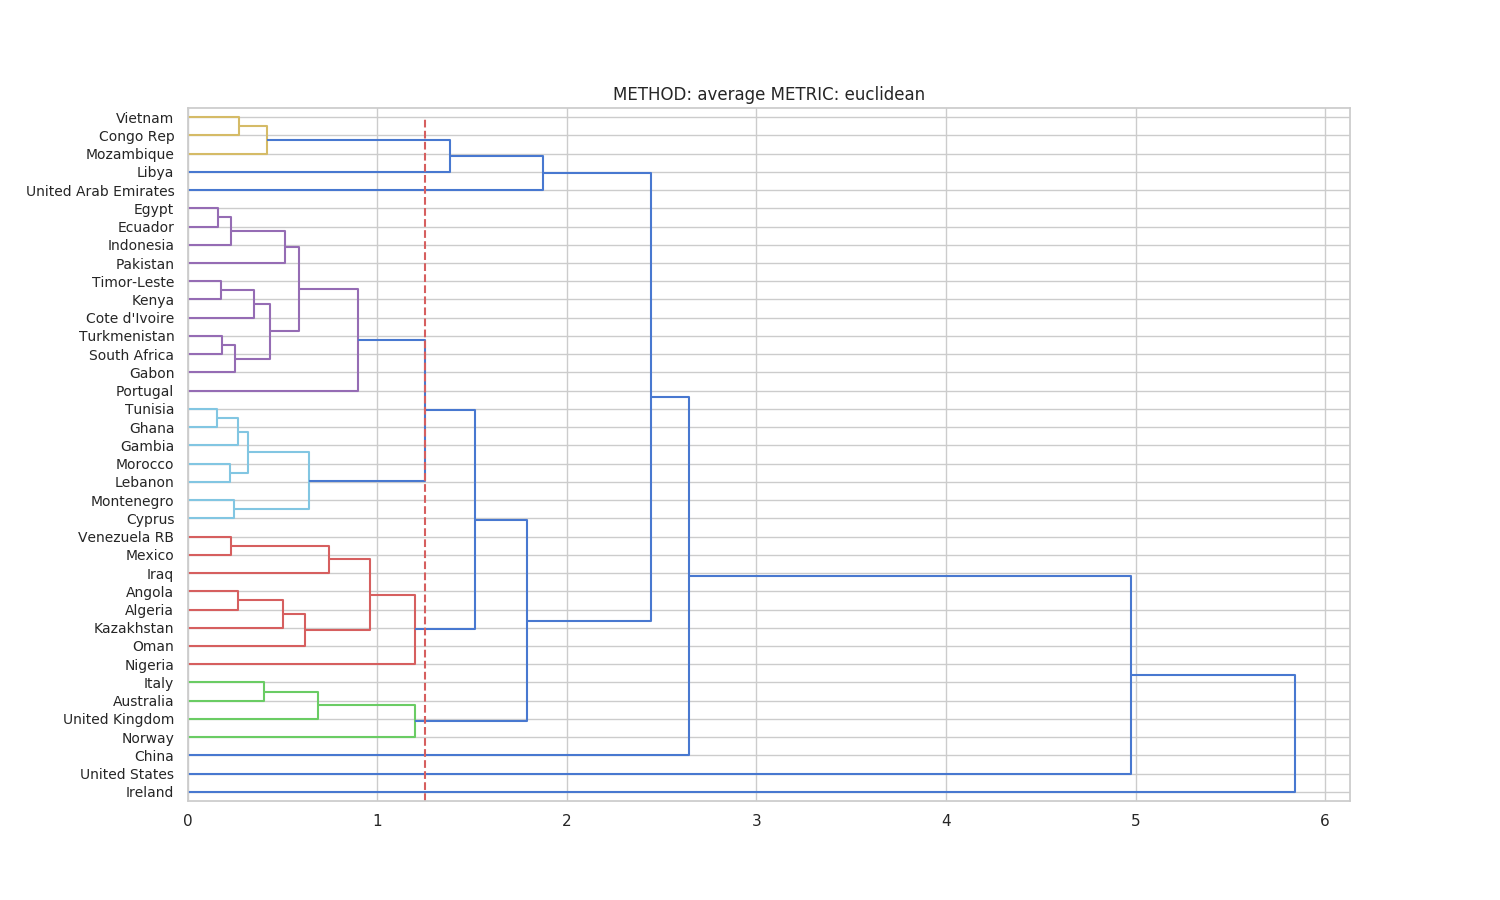

In [21]:
data.hierarchicalClustering(metric='euclidean', method='average', threshold=1.25, on_PC=0, heatmap=False)

In [24]:
#data.hierarchicalClustering(metric='euclidean', method='complete', threshold=1.5, on_PC=on_PC, heatmap=False)

After the analysis of:
- the best **number of clusters** for K-Means and the Gaussian Mixture Model
- the best **linkage methods and thresholds** for Hierarchical Clustering

The following clusterings have been computed:

In [39]:
del data.clusterings_labels['bayesian gm15']
sorted(data.clusterings_labels.keys())

['bayesian gm14',
 'gm14',
 'hc_average_euclidean_0.85',
 'hc_average_euclidean_1.25',
 'hc_ward_euclidean_1.6',
 'hdbscan',
 'kmeans8']

In [40]:
# Compare multiple clusterings through 3D plotting

fig = tl.make_subplots(rows=4, cols=2,
                          print_grid=False,
                          specs=[[{'is_3d': True}, {'is_3d': True}],
                                 [{'is_3d': True}, {'is_3d': True}],
                                 [{'is_3d': True}, {'is_3d': True}],
                                 [{'is_3d': True}, None]])

X = data.df.values

fignum = 1
row = 1
for name, labels in data.clusterings_labels.items():
    # generate 3D scatter plot
    trace = go.Scatter3d(x=X[:, 0], y=X[:, 1], z=X[:, 2],
                         hovertext=data.country_names,
                         name=name,
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                             cauto=True,
                             color=labels.astype(np.float),
                             colorscale='Rainbow',
                             size = 3.5,
                             opacity=0.99999999999999),
                         hoverlabel=dict(bgcolor='red'))
    col = abs(fignum % 2 - 2)
    # print('name: ', name, 'fignum=', fignum, 'row=',row,'col=',col)
    # append plot to the list
    fig.append_trace(trace, row=row, col=col)
    # update indices
    if fignum % 2 == 0:
        row += 1
    fignum = fignum + 1


fig['layout'].update(height=2000, width=1000)

# set titles to subplots
titles = list(data.clusterings_labels.keys())
fig['layout']['scene'].update(annotations=[dict(z=4, text=titles[0], showarrow=False)])
fig['layout']['scene2'].update(annotations=[dict(z=4, text=titles[1], showarrow=False)])
fig['layout']['scene3'].update(annotations=[dict(z=4, text=titles[2], showarrow=False)])
fig['layout']['scene4'].update(annotations=[dict(z=4, text=titles[3], showarrow=False)])
fig['layout']['scene5'].update(annotations=[dict(z=4, text=titles[4], showarrow=False)])
fig['layout']['scene6'].update(annotations=[dict(z=4, text=titles[5], showarrow=False)])
fig['layout']['scene7'].update(annotations=[dict(z=4, text=titles[6], showarrow=False)])
#fig['layout']['scene8'].update(annotations=[dict(z=4, text=titles[7], showarrow=False)])


Visual comparison of the clusters:

In [41]:
methods = list(data.clusterings_labels.keys())
n_clusters = [len(np.unique(x)) for x in data.clusterings_labels.values()]
ndf = pd.DataFrame(data=list(zip(methods, n_clusters)), columns=['Methods','N.clusters']).set_index('Methods')

In [42]:
from IPython.display import display
display(ndf)
print('\nx = ', data.df.columns[0])
print('y = ', data.df.columns[1])
print('z = ', data.df.columns[2])
py.iplot(fig)

,N.clusters
Methods,
gm14,14
hc_ward_euclidean_1.6,9
hdbscan,6
hc_average_euclidean_0.85,14
hc_average_euclidean_1.25,10
bayesian gm14,4
kmeans8,8



x =  Production_Oil_bdp_Cumulated
y =  MVApe_constantUS$_2015
z =  ImportGoodsServices_%GDP


In [43]:
# data.plotAlongPC(pc1=0, pc2=1, xlim=[-3, 3], ylim=[-2, 2], loadings=True, clustering='kmeans10')

In [45]:
# display all tables of clusters generated by different methods together and export them to excel
# newdf = np.zeros(len(data.clusterings.keys()))
styler = []
for k in sorted(data.clusterings_labels.keys()):
    # export to clustering to csv
    df_current = pd.DataFrame(data.clusterings[k])
    path = './data/result_' + k + '.csv'
    df_current.to_csv(path_or_buf=path)
    # visualize tables
    styler.append(data.clusterings[k].style.set_table_attributes("style='display:inline'"))
display_html(styler[0]._repr_html_() + styler[1]._repr_html_() + styler[2]._repr_html_() + styler[3]._repr_html_() + styler[4]._repr_html_() + styler[5]._repr_html_() + styler[6]._repr_html_(), raw=True)

,bayesian gm14
Cluster,
0,"['Algeria', 'Angola', 'China', ""Cote d'Ivoire"", 'Ecuador', 'Egypt', 'Gabon', 'Ghana', 'Indonesia', 'Iraq', 'Kazakhstan', 'Kenya', 'Lebanon', 'Mexico', 'Morocco', 'Nigeria', 'Oman', 'Pakistan', 'South Africa', 'Timor-Leste', 'Tunisia', 'Turkmenistan', 'United Arab Emirates', 'Venezuela RB', 'Gambia']"
1,"['Australia', 'Congo Rep', 'Cyprus', 'Italy', 'Libya', 'Montenegro', 'Mozambique', 'Norway', 'Portugal', 'United Kingdom', 'Vietnam']"
2,['Ireland']
3,['United States']
,gm14
Cluster,
0,['China']
1,"[""Cote d'Ivoire"", 'Cyprus', 'Ghana', 'Kenya', 'Lebanon', 'Montenegro', 'Morocco', 'Pakistan', 'South Africa', 'Timor-Leste', 'Tunisia', 'Gambia']"
2,['Ireland']


In [46]:
from collections import defaultdict
from sklearn import metrics

# calculate similarity index
sim = data.clustering_similarities()
sim_index = sim.sum().sort_index()

# Calculate scores to evaluate the different clustering methods
y_true = data.clusterings_labels['kmeans8']
scores = defaultdict()
for k in sorted(data.clusterings_labels.keys()):
    silh = metrics.silhouette_score(data.df, data.clusterings_labels[k], metric='euclidean')
    db = metrics.calinski_harabaz_score(data.df, data.clusterings_labels[k])
    scores[k] = [silh, db]

# Create dataset with the scores
df_scores = pd.DataFrame.from_dict(scores, orient='index', columns=['silhuouette', 'calinski-harabaz']).sort_index()
df_scores.iloc[:, 0] = scale(df_scores)[:, 0]
df_scores.iloc[:, 1] = scale(df_scores)[:, 1]
df_scores['Similarity Index'] = scale(sim_index.sort_index())
df_scores['Sum'] = df_scores.sum(axis=1)

df_scores.sort_values(by='Sum', ascending=False).style.apply(highlight_max) 

,silhuouette,calinski-harabaz,Similarity Index,Sum
kmeans8,1.22229,0.544658,0.61791,2.38486
hc_ward_euclidean_1.6,0.820628,0.643837,0.866046,2.33051
hc_average_euclidean_1.25,0.865998,0.553922,0.82394,2.24386
hc_average_euclidean_0.85,0.304079,1.44478,0.402119,2.15098
hdbscan,-0.718423,-1.57957,0.115316,-2.18267
gm14,-1.67306,-0.572152,-0.697462,-2.94268
bayesian gm14,-0.821512,-1.03548,-2.12787,-3.98486


As we expected, KMeans is obtaining the highest Silhouette Score since its K=8 (N. of clusters) was optimised on it, whereas the Hierarchical Clustering with average method and low threshold (0.85) is getting the highest Calinski-Harabaz Sccore, probably beacause of the higher number of single-element clusters (--> higher inter-cluster variance and lower intra-cluster variance).

Taking into consideration both these results and a visual comparison of the clusters, **kmeans8** results to be the best clustering available.

**Silhouette Score**

--> http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient
--> Peter J. Rousseeuw (1987). “Silhouettes: a Graphical Aid to the Interpretation and Validation of Cluster Analysis”. Computational and Applied Mathematics 20

Our Silhouette Score is the mean Silhouette Coefficient over all samples. The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of.

2.3.9.5.1. Advantages

    The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
    The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

2.3.9.5.2. Drawbacks

    The Silhouette Coefficient is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

**Calinski and Harabaz score**

--> http://scikit-learn.org/stable/modules/clustering.html#calinski-harabaz-index
--> Caliński, T., & Harabasz, J. (1974). “A dendrite method for cluster analysis”. Communications in Statistics-theory and Methods 3: 1-27

Also known as the Variance Ratio Criterion, this score is defined as ratio between the within-cluster dispersion and the between-cluster dispersion.

2.3.9.6.1. Advantages¶

    The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
    The score is fast to compute

2.3.9.6.2. Drawbacks

    The Calinski-Harabaz index is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.




# HOVER CHE FUNZIONANO MA UN SOLO PLOT

In [27]:
# import plotly.plotly as py
# import pandas as pd

# df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/alpha_shape.csv')
# df.head()

# fig = tools.make_subplots(rows=2, cols=3,
#                           print_grid=True,
#                           specs=[[{'is_3d': True}, {'is_3d': True}, {'is_3d': True}],
#                                  [ {'is_3d': True, 'rowspan':1}, None, None]])
# fig = fig.to_dict()
# X = data.df.values

# fignum = 1
# content = []
# for name, labels in data.clusterings_labels.items():
    
#     scatter = dict(
#         mode = "markers",
#         name = name,
#         type = "scatter3d",    
#         x=X[:, 0], y=X[:, 1], z=X[:, 2],
#         marker=dict(
#              cauto=True,
#              color=labels.astype(np.float),
#              colorscale='Rainbow',
#              line=dict(color='black', width=1)),
#         hoverlabel=dict(bgcolor='orange'),
#         hovertext=data.country_names)
    
#     content.append(scatter)

# layout = dict(
#     title = '3d point clustering',
#     scene = dict(
#         xaxis = dict( zeroline=False ),
#         yaxis = dict( zeroline=False ),
#         zaxis = dict( zeroline=False ),
#     ))
# fig = go.Figure(data=content)
# # Use py.iplot() for IPython notebook
# py.iplot(fig, filename='3d point clustering')

In [28]:
d_fig = fig.to_dict()
print(type(d_fig))
print(len(d_fig))
print(type(d_fig['data']))
print(len(d_fig['data']))

<class 'dict'>
2
<class 'list'>
7
